<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S5/eva_session5%20-%20iter%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iteration 5



Target
1. Apply LR Scheduler
In previous iteration, the model accuracy was decreasing after 5th epoch so LR step is set to 5.
2. Used rotation in transformation.

Results
1. parameters = 6,398
2. Best Train Accuracy = 99.28
3. Best Test Accuracy = 99.44

Analysis
1. Good Model! The model has crossed the target accuracy. Less fluctuation in test accuracy.

2. The model is underfitting which is expected.

3. The model performed well in last 7-8 epochs maintaining a greater then 99.41% for 4-5 epochs. Still not showing complete consistency in accuracy.

4. The model is capable of pushing further.



---

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

!pip install torchsummary
from torchsummary import summary

## Getting to know our data

In [2]:
# Downloading the dataset and setting up dataloader for visualisationn only

train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)

torch.Size([64, 1, 28, 28])
torch.Size([64])




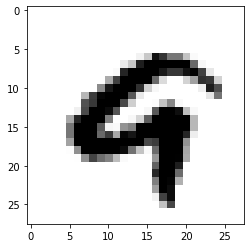

In [3]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_set.train_data
train_data = train_set.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_set.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_set.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

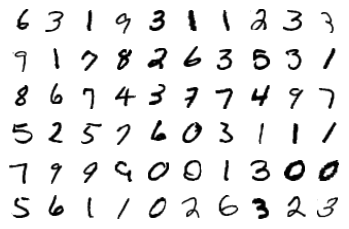

In [4]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Setting up Dataloaders and Transformations


In [53]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),    
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [54]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [55]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_set = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_set = datasets.MNIST('../data', train=False, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_set , batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)


## Making our model

In [62]:
# dropout_rate = 0.02

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, bias=False), # RF - 3x3
            nn.BatchNorm2d(10),
            nn.ReLU(),
            # nn.Dropout(dropout_rate), # RF - 3x3
            
            nn.Conv2d(10, 10, 3, bias=False), # RF - 5x5
            nn.BatchNorm2d(10),
            nn.ReLU(),
            # nn.Dropout(dropout_rate), # RF - 5x5

            nn.MaxPool2d(2, 2), # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, bias=False), # RF - 12x12
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # nn.Dropout(dropout_rate), # RF - 12x12

            nn.Conv2d(16, 16, 3, bias=False), # RF - 14x14
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            # nn.Dropout(dropout_rate), # RF - 14x14

            nn.MaxPool2d(2, 2), # RF - 28x28
            
            nn.Conv2d(16, 10, 3, bias=False), # RF - 30x30
            nn.BatchNorm2d(10),
            nn.ReLU(),
            # nn.Dropout(dropout_rate) # RF - 30x30

        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 1, bias=False), # RF - 30x30
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.mean(dim=[-2,-1]) # GAP Layer

        x = x.view(-1, 10)
        return F.log_softmax(x)

In [63]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,440
      BatchNorm2d-11           [-1, 16, 10, 10]              32
             ReLU-12           [-1, 16, 10, 10]               0
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [58]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    print(f"EPOCH - {epoch}")
    model.train()
    pbar = tqdm(train_loader, position=0, leave=True)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [59]:
data, target = next(iter(train_loader))
print(data.size(), target.size())

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [65]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.15)

for epoch in range(1, 16):
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH - 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.03942801058292389 Batch_id=937 Accuracy=91.64: 100%|██████████| 938/938 [00:20<00:00, 45.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9839/10000 (98%)

EPOCH - 2


Loss=0.17663581669330597 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:20<00:00, 46.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9890/10000 (99%)

EPOCH - 3


Loss=0.14733704924583435 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:19<00:00, 47.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9911/10000 (99%)

EPOCH - 4


Loss=0.06289128214120865 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:19<00:00, 46.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9901/10000 (99%)

EPOCH - 5


Loss=0.0065079135820269585 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:20<00:00, 46.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99%)

EPOCH - 6


Loss=0.19037288427352905 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:19<00:00, 47.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99%)

EPOCH - 7


Loss=0.01146039366722107 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:19<00:00, 47.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99%)

EPOCH - 8


Loss=0.011286795139312744 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:19<00:00, 46.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99%)

EPOCH - 9


Loss=0.004256749991327524 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:21<00:00, 44.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99%)

EPOCH - 10


Loss=0.02676350809633732 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:21<00:00, 44.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99%)

EPOCH - 11


Loss=0.021598579362034798 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:21<00:00, 44.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99%)

EPOCH - 12


Loss=0.03776874020695686 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:22<00:00, 41.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99%)

EPOCH - 13


Loss=0.059294361621141434 Batch_id=937 Accuracy=99.26: 100%|██████████| 938/938 [00:22<00:00, 40.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99%)

EPOCH - 14


Loss=0.004679540172219276 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:22<00:00, 42.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99%)

EPOCH - 15


Loss=0.0070029995404183865 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:22<00:00, 42.08it/s]



Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

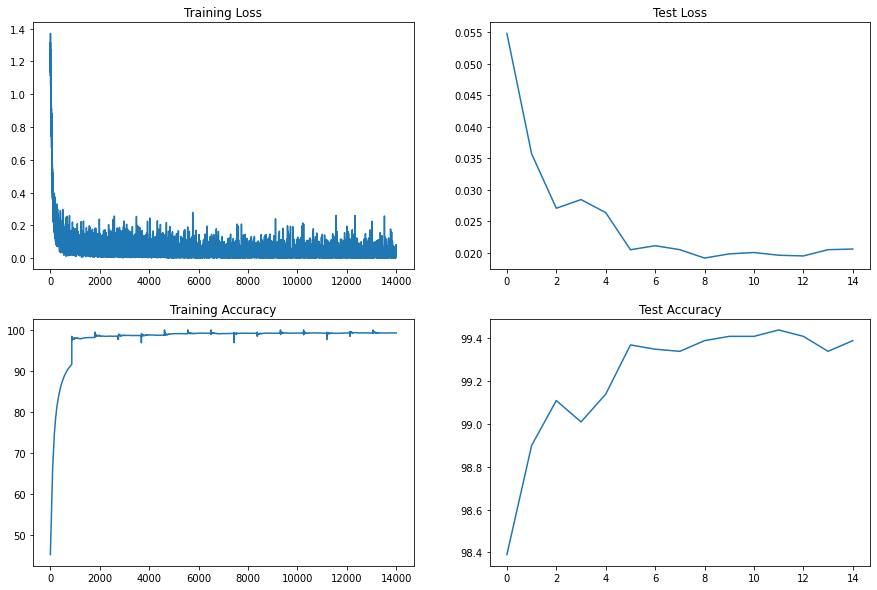

In [81]:

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")